# Practical Bayesian Hyperparameter Optimization


### Import librairies

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.gaussian_process as gp
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn import datasets
from matplotlib import rc
from sklearn.model_selection import KFold, StratifiedKFold

%matplotlib inline

# Evaluation of the model
from sklearn.model_selection import KFold, train_test_split
# Governing choices for search
N_FOLDS = 5
MAX_EVALS = 5


### Definition of the “Expected Improvement” acquisition function
Settings:
* x: array type, point to calculate
* gaussian_process: The Gaussian process previously trained on the hyperparameters    
* evaluated_loss: Numpy array containing previously evaluated loss function values
* greater_is_better: Boolean indicating whether to maximize or minimize the loss function
* n_params: int indicating the dimension of the hyperparameters

In [3]:
def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):
    x_to_predict = x.reshape(-1, n_params)  # Reshape x to match the number of parameters

    # Predict the mean and standard deviation of the loss at points x
    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    # Determine the best loss value based on the greater_is_better flag
    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    # Scaling factor for the calculation based on whether greater loss is better
    scaling_factor = (-1) ** (not greater_is_better)

    # Calculate the Expected Improvement (EI)
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = (scaling_factor * (mu - loss_optimum) * norm.cdf(Z) +
                                sigma * norm.pdf(Z))
        expected_improvement[sigma == 0.0] = 0.0  # Handle the case where sigma is zero

    return expected_improvement

### Function determining the next acquisition point:
Settings:
* acquisition_func: acquisition function to optimize
* gaussian_process: The Gaussian process previously trained on the hyperparameters
* evaluated_loss: Numpy array containing previously evaluated loss function values
* greater_is_better: Boolean indicating whether to maximize or minimize the loss function
* bounds: Tuple indicating the definition limits for the L-BFGS "optimizer"
* n_restarts: int indicating the number of iterations performed on the minimizer with different values

In [4]:
def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):

    # Initialisation :
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))
        #Hyperparameter change condition:
        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

        print(f"Best acquisition value is {best_acquisition_value}")

    return best_x

### Function optimizing the loss function using Gaussian processes
Settings:
* n_iters: int indicating the number of iterations to use
* sample_loss: function to optimize
* bounds: Array indicating the bounds of the loss function
* x0: array defining initial points where to evaluate the loss function. If x0=None these points are chosen randomly
* n_pre_samples: int indicating the number of initial points if x0=None
* gp_params: dictionary indicating the hyperparameters to pass to the Gaussian process.
* random_search: Boolean indicating whether we use a random search or an L-BFGS optimization on the acquisition function
* alpha: double indicating the variance associated with the Gaussian Process error term
* epsilon: double indicating the tolerance level for float evaluation

In [5]:
# Bayesian Optimization function (as defined previously)
def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):
    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern(nu=5/2)
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):
        model.fit(xp, yp)

        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, greater_is_better=True, bounds=bounds, n_restarts=100)

        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        cv_score = sample_loss(next_sample)

        x_list.append(next_sample)
        y_list.append(cv_score)

        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

### Functions for displaying results at each iteration
The following functions will be used to create graphs to illustrate the implementation of the optimization.
The graphs obtained will represent on the abscissa and ordinate our different hyperparameters with a color code corresponding to isovalues ​​of the loss function and the Expected Improvement respectively.
Settings:
* first_param_grid: Array which contains the grid of points to display for the first parameter.
* sampled_params: Points for which the value of the loss function is calculated.
* sampled_loss: Loss function used
* first_iter: First iteration to display
* alpha: Variance of the error in the GP model
* greater_is_better: boolean indicates whether we want to maximize or minimize the loss function.
* true_y: array containing the true value of the loss for comparative display.
* second_param_grid: Array which contains the grid of points to display for the second parameter.
* param_dims_to_plot: list of `sampled_params` indices containing the first and second parameters.
* optimum: maximum value of the loss function


In [6]:
def plot_iteration(first_param_grid, sampled_params, sampled_loss, first_iter=0, alpha=1e-5,
                   greater_is_better=True, true_y=None, second_param_grid=None,
                   param_dims_to_plot=[0, 1], filepath=None, optimum=None):


    # Create the GPMatern
    kernel = gp.kernels.Matern(nu=5/2)
    model = gp.GaussianProcessRegressor(kernel=kernel,
                                        alpha=alpha,
                                        n_restarts_optimizer=10,
                                        normalize_y=True)

    # Don't show the last iteration (next_sample is not available then)
    for i in range(first_iter, sampled_params.shape[0] - 1):
        model.fit(X=sampled_params[:(i + 1), :], y=sampled_loss[:(i + 1)])

        if second_param_grid is None:
            # 1-dimensional case: line plot
            mu, std = model.predict(first_param_grid[:, np.newaxis], return_std=True)
            ei = -1 * expected_improvement(first_param_grid, model, sampled_loss[:(i + 1)],
                                           greater_is_better=greater_is_better, n_params=1)

            fig, ax1, ax2 = _plot_loss_1d(first_param_grid, sampled_params[:(i + 1), :], sampled_loss[:(i + 1)], mu, std, ei, sampled_params[i + 1, :], yerr=alpha, true_y=true_y)
        else:
            # Transform grids into vectors for EI evaluation
            param_grid = np.array([[first_param, second_param] for first_param in first_param_grid for second_param in second_param_grid])

            mu, std = model.predict(param_grid, return_std=True)
            ei = -1 * expected_improvement(param_grid, model, sampled_loss[:(i + 1)],
                                           greater_is_better=greater_is_better, n_params=2)

            fig, ax1, ax2 = _plot_loss_2d(first_param_grid, second_param_grid, sampled_params[:(i+1), param_dims_to_plot],sampled_loss,mu, ei, sampled_params[i + 1, param_dims_to_plot], optimum)

        if filepath is not None:
             plt.savefig('%s/bo_iteration_%d.png' % (filepath, i), bbox_inches='tight')


def _plot_loss_1d(x_grid, x_eval, y_eval, mu, std, ei, next_sample, yerr=0.0, true_y=None):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True)

    # Loss function plot
    ax1.plot(x_grid, mu, label = "GP mean")
    ax1.fill_between(x_grid, mu - std, mu + std, alpha=0.5)
    ax1.errorbar(x_eval, y_eval, yerr, fmt='ok', zorder=3, label="Observed values")
    ax1.set_ylabel("Function value f(x)")
    ax1.set_xlabel("x")

    if true_y is not None:
        ax1.plot(x_grid, true_y, '--', label="True function")

    # Acquisition function plot
    ax2.plot(x_grid, ei, 'r', label="Expected improvement")
    ax2.set_ylabel("Expected improvement (EI)")
    ax2.set_title("Next sample point is C = %.3f" % next_sample)
    ax2.axvline(next_sample)

    return fig, ax1, ax2

def _plot_loss_2d(first_param_grid, second_param_grid, sampled_params, sampled_loss, mu, ei, next_sample, optimum=None):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8), sharex=True, sharey=True)

    X, Y = np.meshgrid(first_param_grid, second_param_grid, indexing='ij')

    # EI contour plot
    cp = ax1.contourf(X, Y, ei.reshape(X.shape))
    plt.colorbar(cp, ax=ax1)
    ax1.set_title("Expected Improvement. Next sample will be (%.2f, %.2f)" % (next_sample[0], next_sample[1]))
    ax1.autoscale(False)
    ax1.axvline(next_sample[0], color='k')
    ax1.axhline(next_sample[1], color='k')
    ax1.scatter(next_sample[0], next_sample[1])
    ax1.set_xlabel("hyper-param1")
    ax1.set_ylabel("hyper-param2")

    # Loss contour plot
    cp2 = ax2.contourf(X, Y, mu.reshape(X.shape))
    plt.colorbar(cp2, ax=ax2)
    ax2.autoscale(False)
    ax2.scatter(sampled_params[:, 0], sampled_params[:, 1], zorder=1)
    ax2.axvline(next_sample[0], color='k')
    ax2.axhline(next_sample[1], color='k')
    ax2.scatter(next_sample[0], next_sample[1])
    ax2.set_title("Mean estimate of loss surface for iteration %d" % (sampled_params.shape[0]))
    ax2.set_xlabel("hyper-param1")
    ax2.set_ylabel("hyper-param2")

    if optimum is not None:
        ax2.scatter(optimum[0], optimum[1], marker='*', c='red', s=150)

    return fig, ax1, ax2


## 1. SGDClassifier

Here we will try to optimize the hyperparameters of the sklearn SGDClassifier classification algorithm with loss='hinge' on our iris dataset:

In [13]:
from sklearn.datasets import load_diabetes

# Load the Diabetes dataset
# data ,target = load_diabetes(as_frame=True,return_X_y= True )

data, target = load_iris(return_X_y=True)

# We define our classifier here:

def sample_loss(params):
    alpha = 10 ** params[0]
    l1_ratio = params[1]
    # max_iter = int(params[2])
    # tol = 10 ** params[3]

    clf = SGDClassifier(alpha=alpha, l1_ratio=l1_ratio, loss='hinge')  #,tol=tol  , max_iter=max_iter
    return -cross_val_score(clf, X=data, y=target, cv=3).mean()

We are looking for an optimal value of the hyperparameters indicated by a red star on our future graphs.

Below code is for manual Grid search

In [14]:
# Define the parameter space
alphas = np.linspace(-5, 1, 50)
l1_ratios = np.linspace(0, 1, 50)
max_iterations = np.linspace(1, 2000, 10)
tols = np.linspace(-5, 0, 10)

# Create a parameter grid with all combinations of the four variables
param_grid = np.array([[alpha, l1_ratio]  #, max_iter, tol
                       for alpha in alphas
                       for l1_ratio in l1_ratios
                      #  for max_iter in max_iterations
                      #  for tol in tols
                       ])

# Calculate the loss associated with each combination of hyperparameters
real_loss = [sample_loss(params) for params in param_grid]

# Determine the optimal hyperparameters
maximum = param_grid[np.array(real_loss).argmax(), :]

print("Optimal hyperparameters found by grid search:")
print(maximum)

Optimal hyperparameters found by grid search:
[-4.87755102  0.28571429]


 Bayesian optimization below:

In [9]:
# We determine the space in which our parameters evolve
bounds = np.array([
    [-5, 1],     # Logarithm of alpha
    [0, 1],      # L1 ratio
    # [1, 2000],   # max_iter (number of iterations)
    # [-5, 0]      # Logarithm of tol (tolerance)
])

# On lance notre algorithme d'optimisation
xp, yp = bayesian_optimisation(
    n_iters=30,
    sample_loss=sample_loss,
    bounds=bounds,
    n_pre_samples=3,
    random_search=1000
)

# Print results
print("Evaluated points:")
# print(xp)
print("Corresponding losses:")
# print(yp)

# Find the best parameters
best_index = np.argmin(yp)
best_x = xp[best_index]
best_y = yp[best_index]

# Output the best parameters and best accuracy
print(f"Best parameters: alpha={10 ** best_x[0]}, l1_ratio={10 ** best_x[1]}")
print(f"Best accuracy: {-best_y}")

Evaluated points:
Corresponding losses:
Best parameters: alpha=0.006550396799870522, l1_ratio=2.1240961162255285
Best accuracy: 0.9466666666666667


 Displaying the results obtained by the Bayesian optimization for the loss function and the Expected Improvement for each iteration:

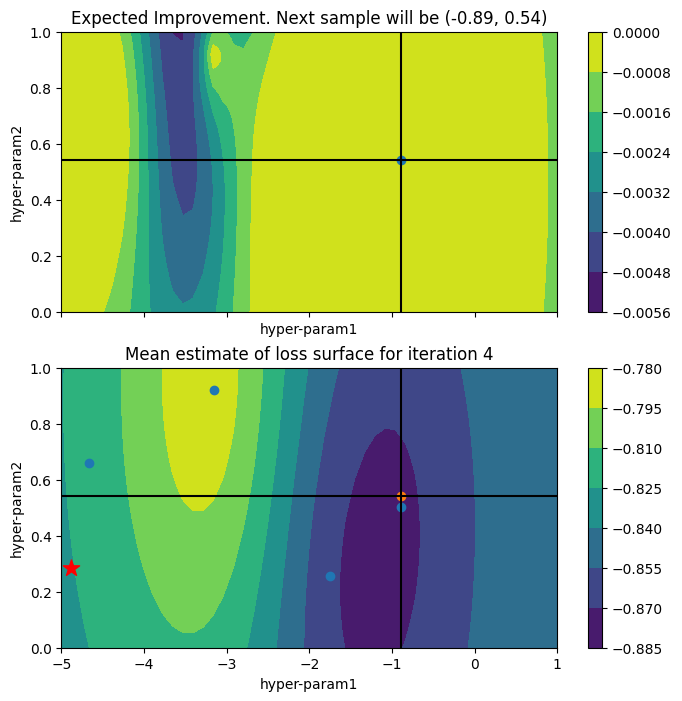

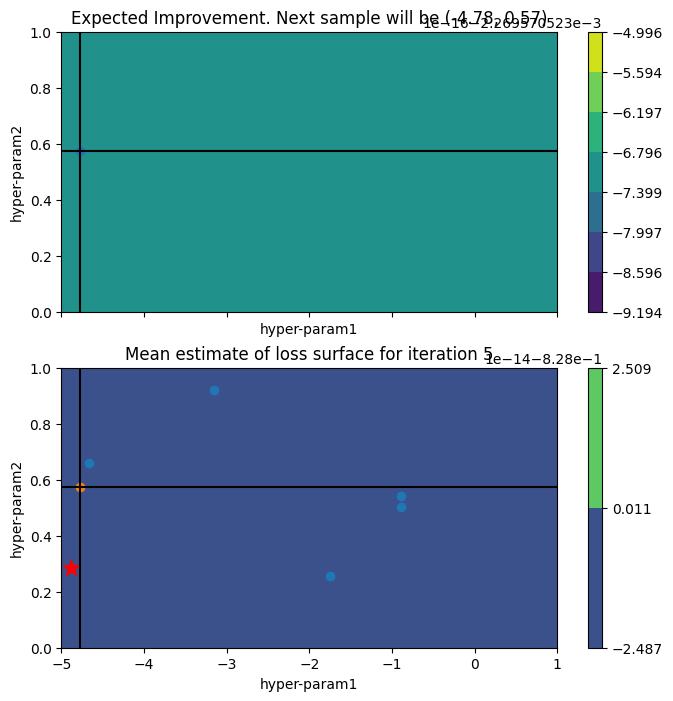

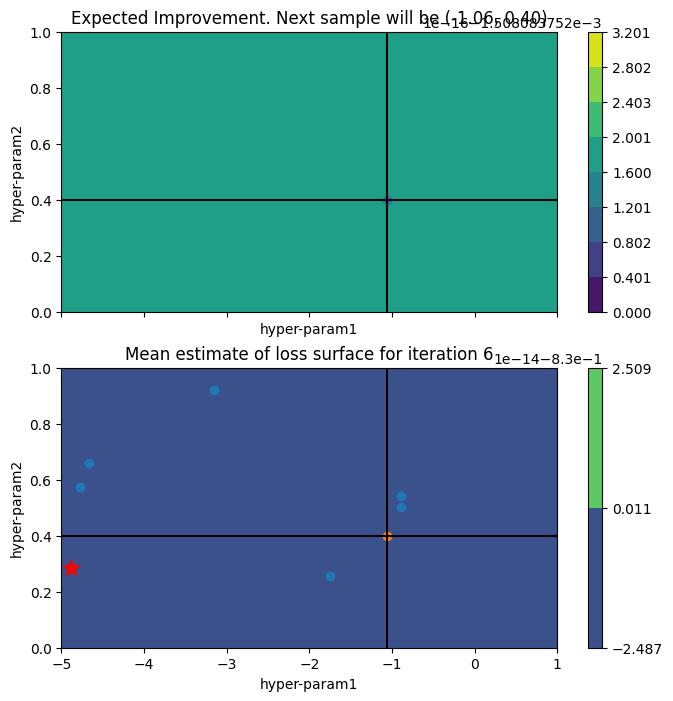

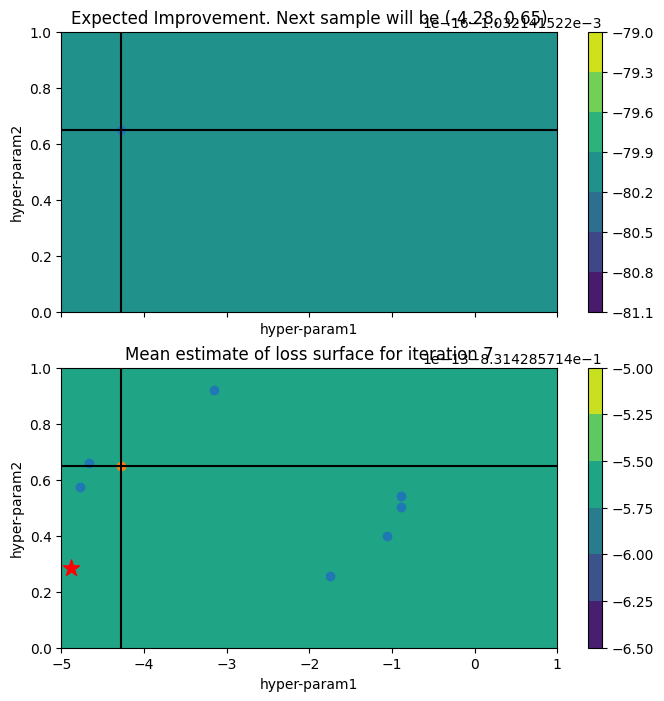

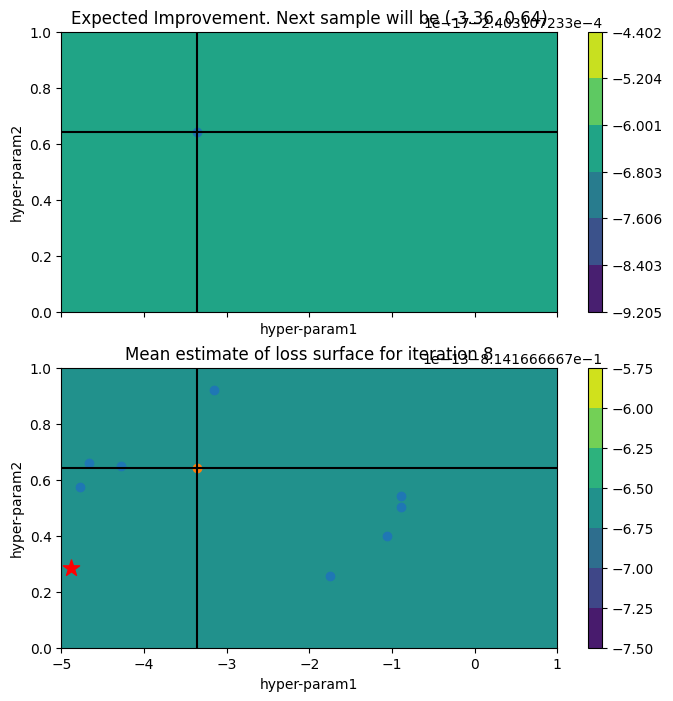

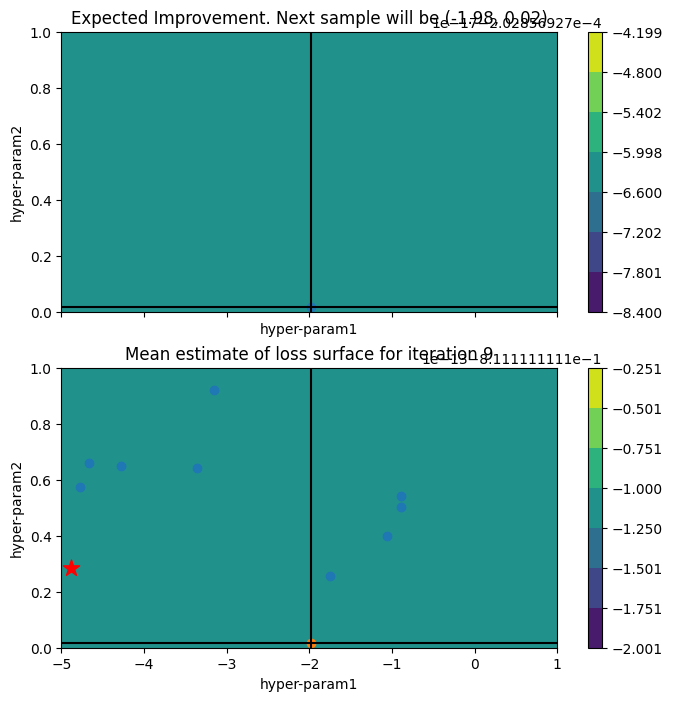

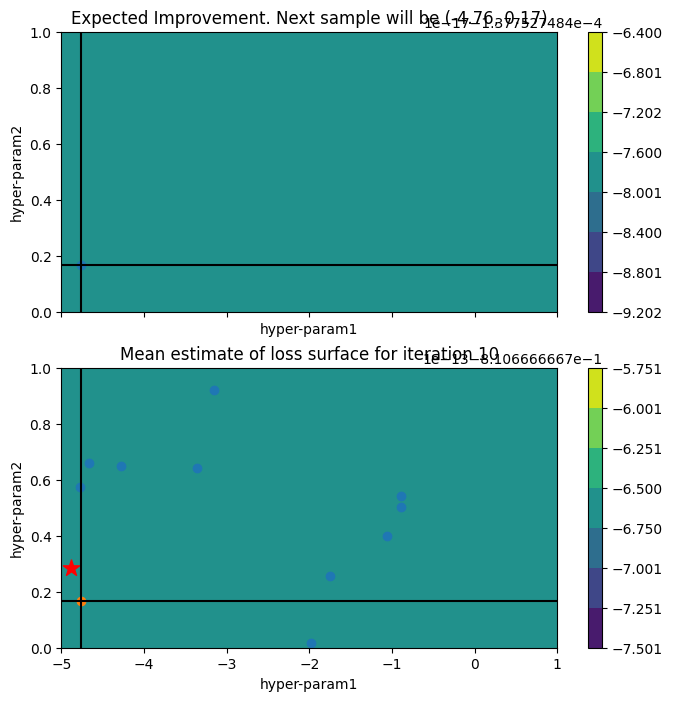

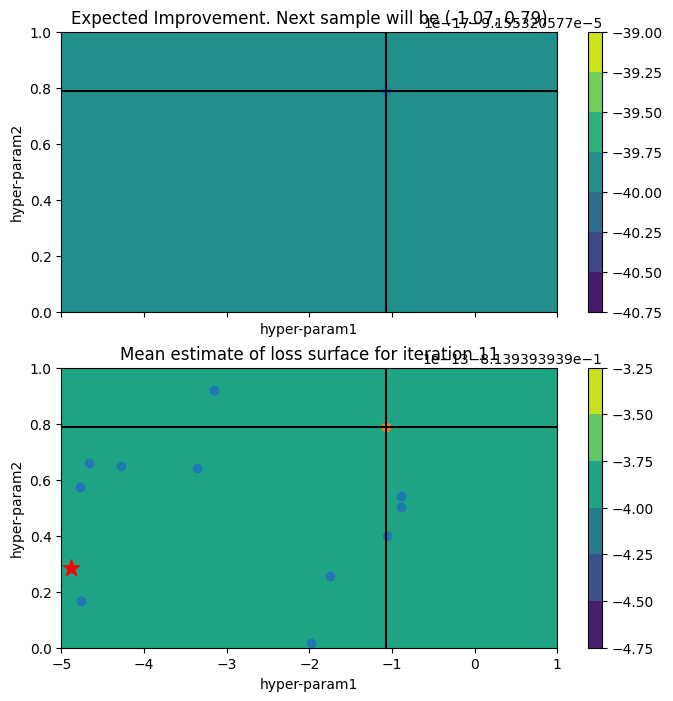

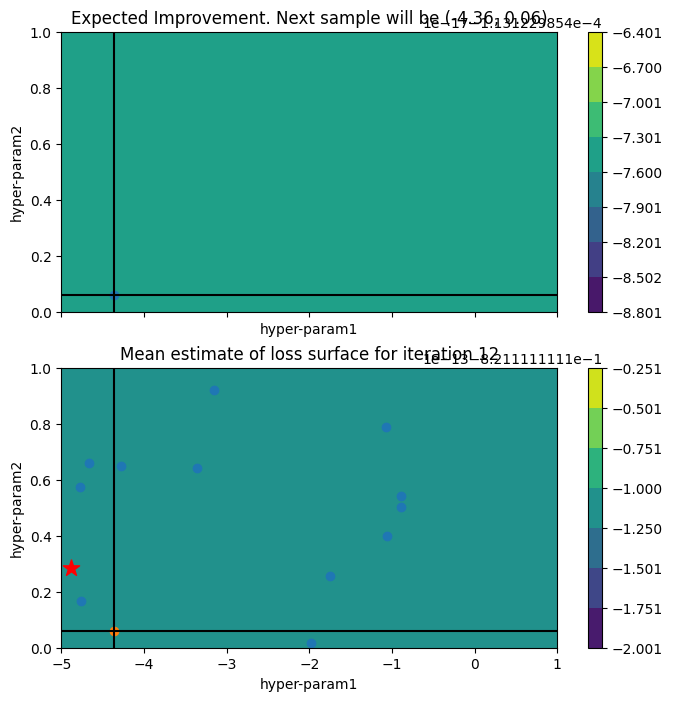

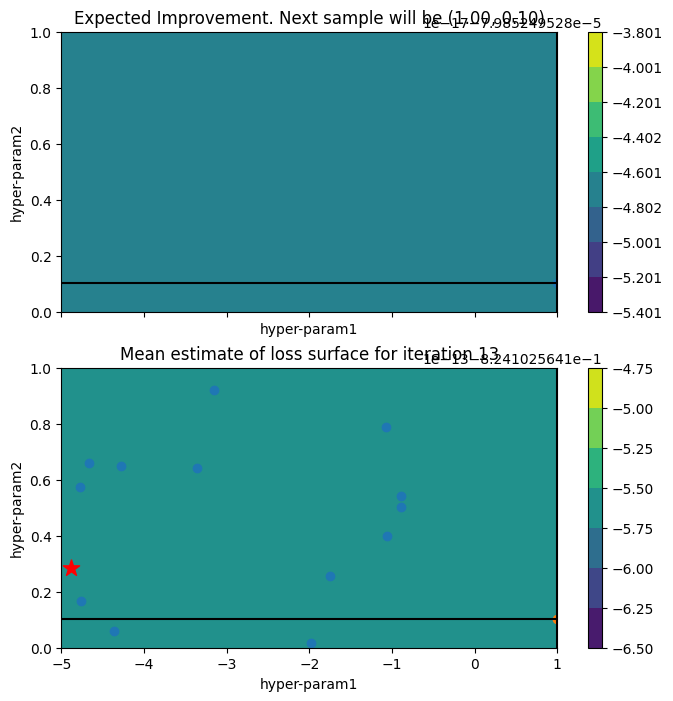

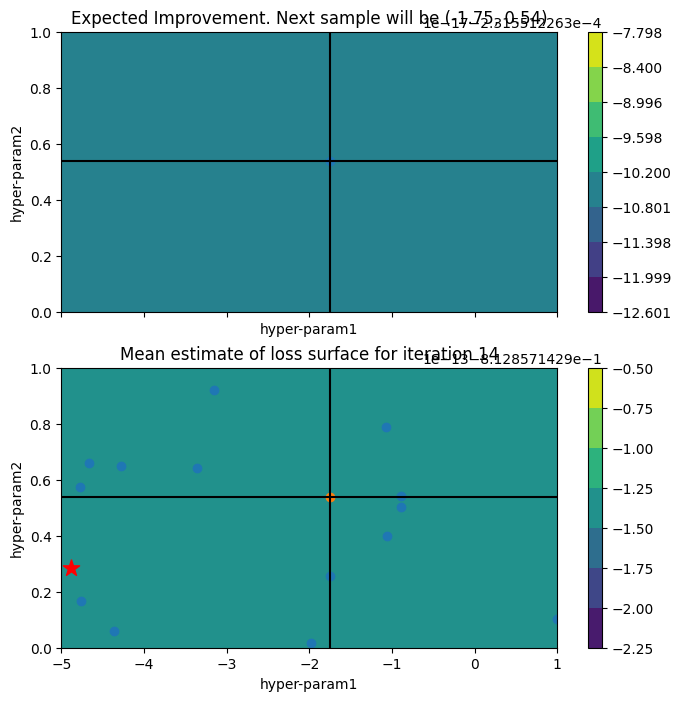

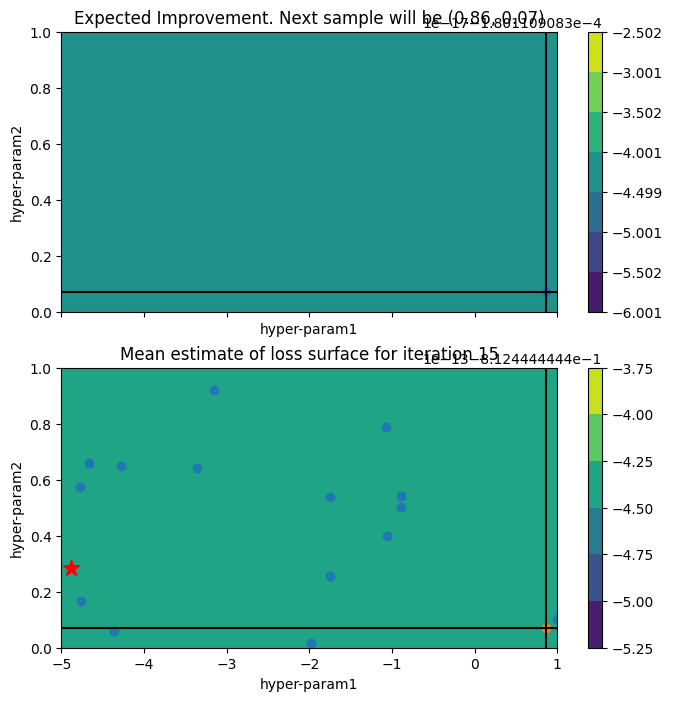

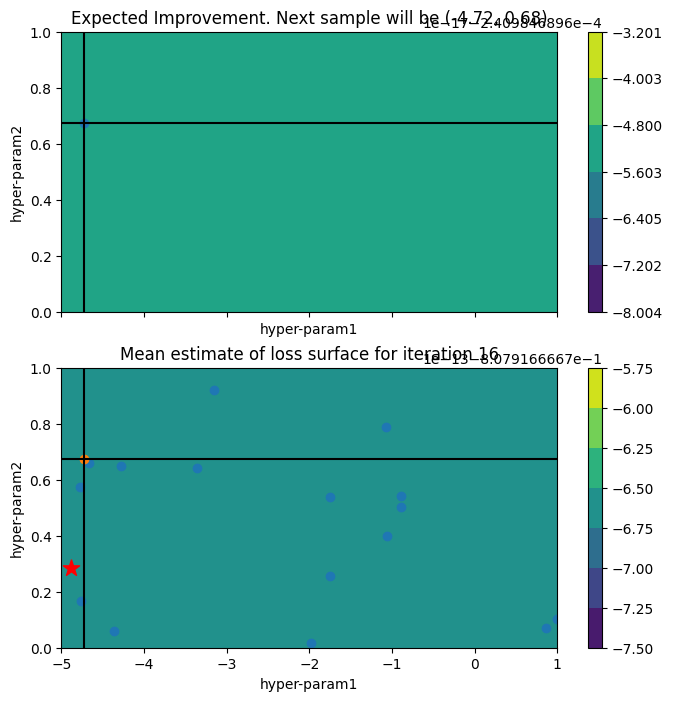

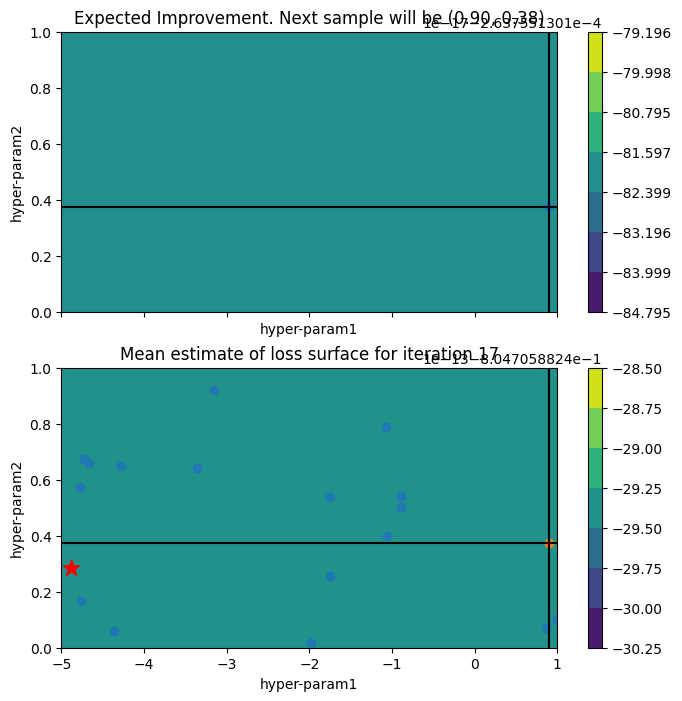

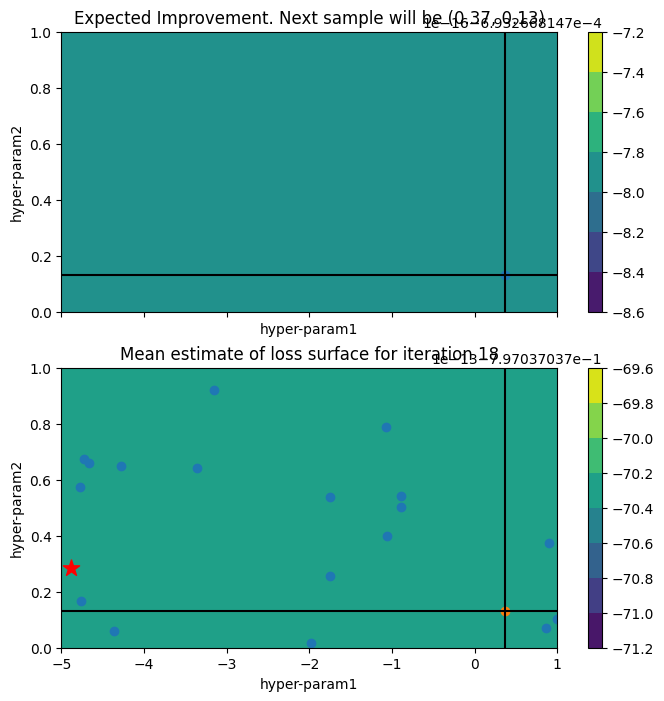

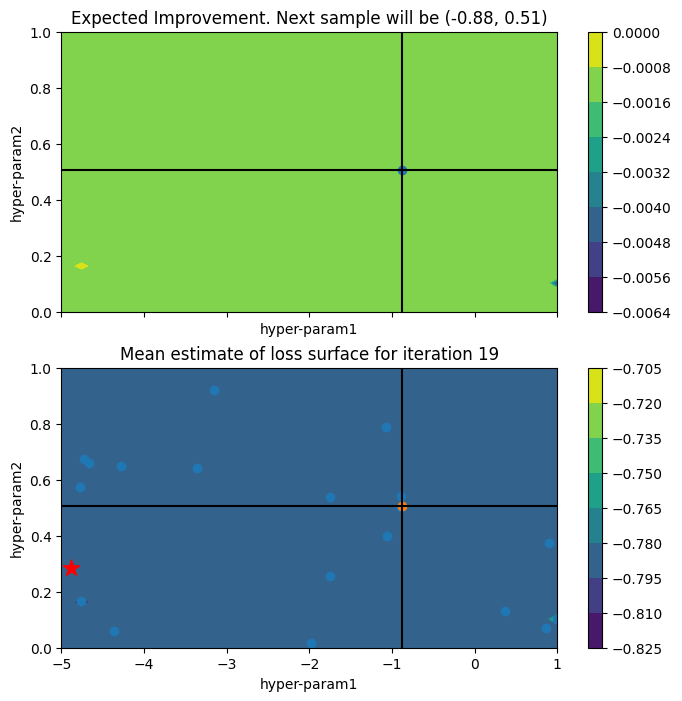

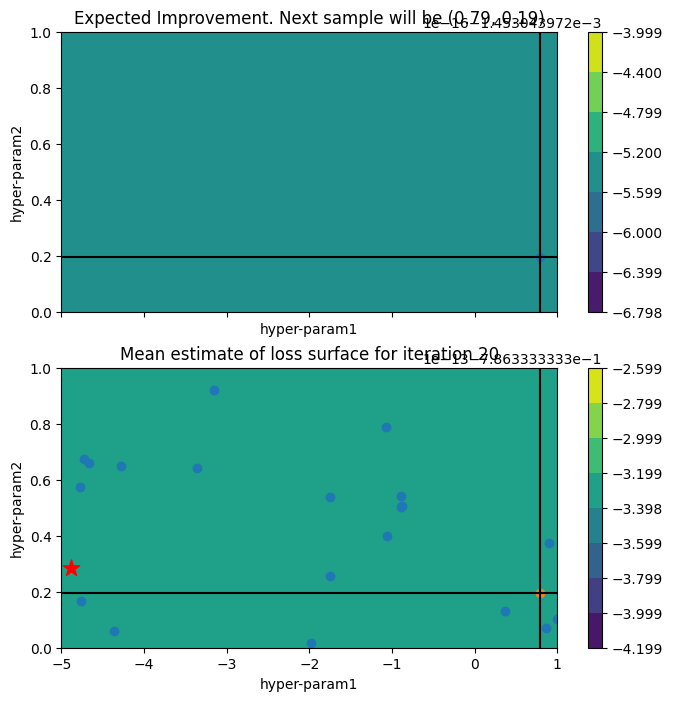

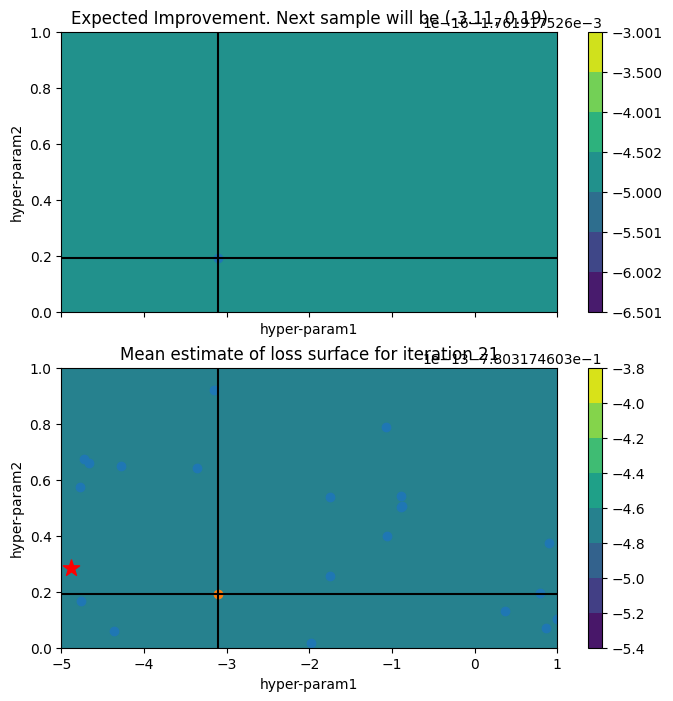

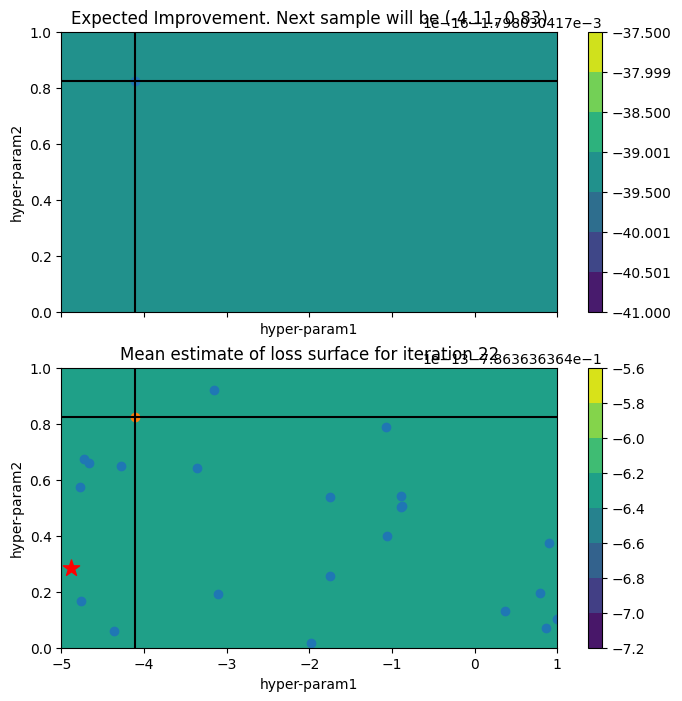

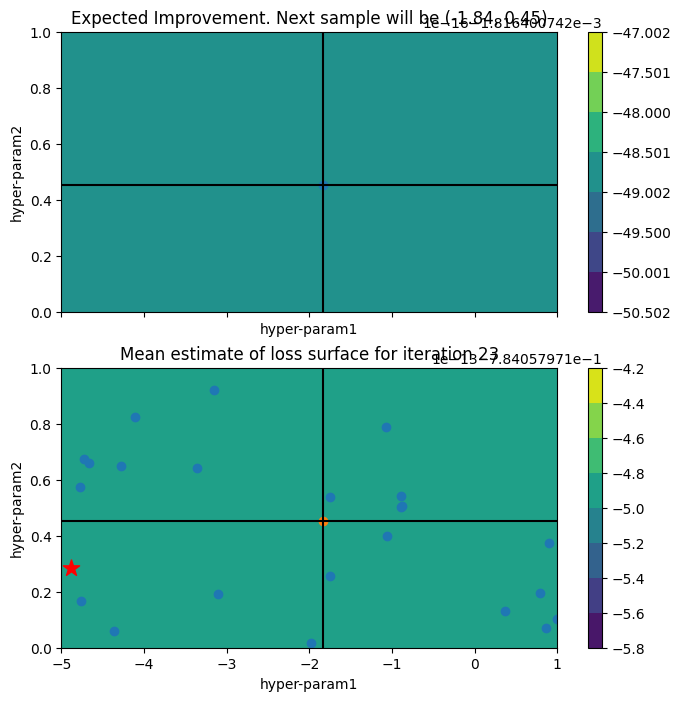

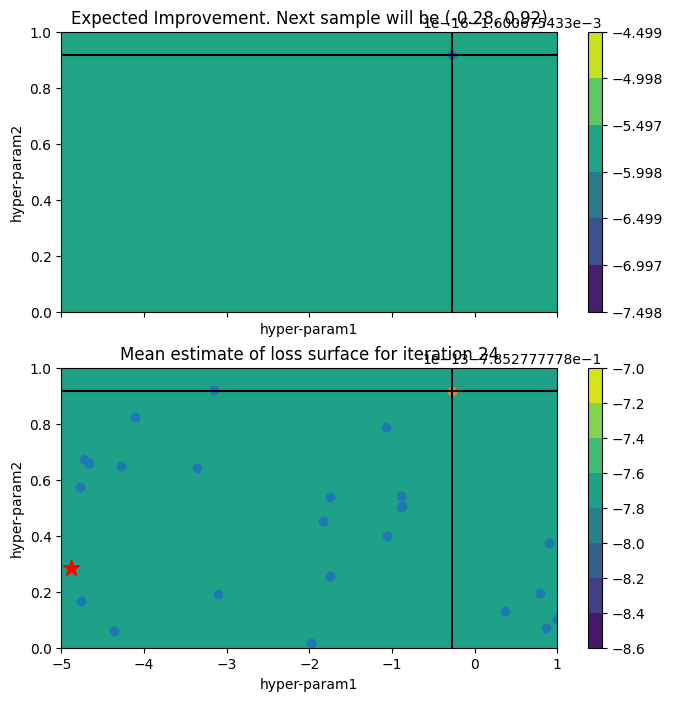

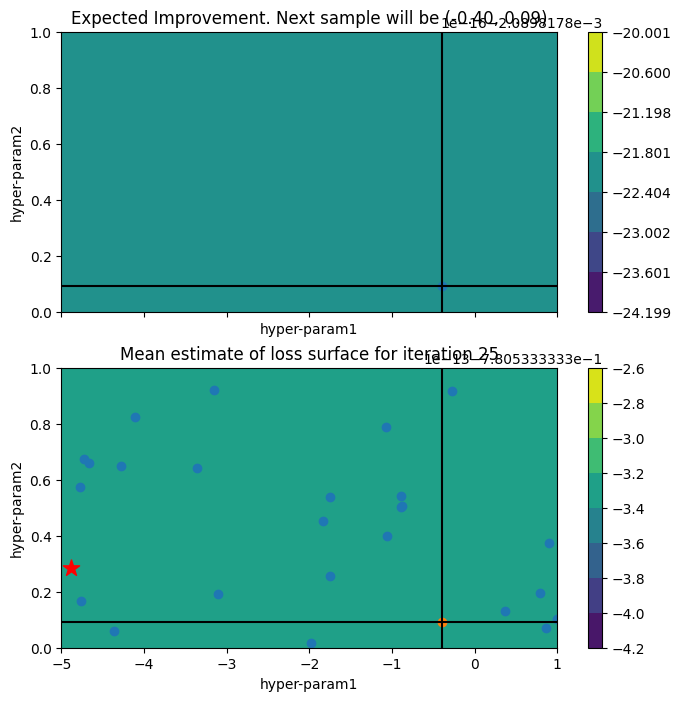

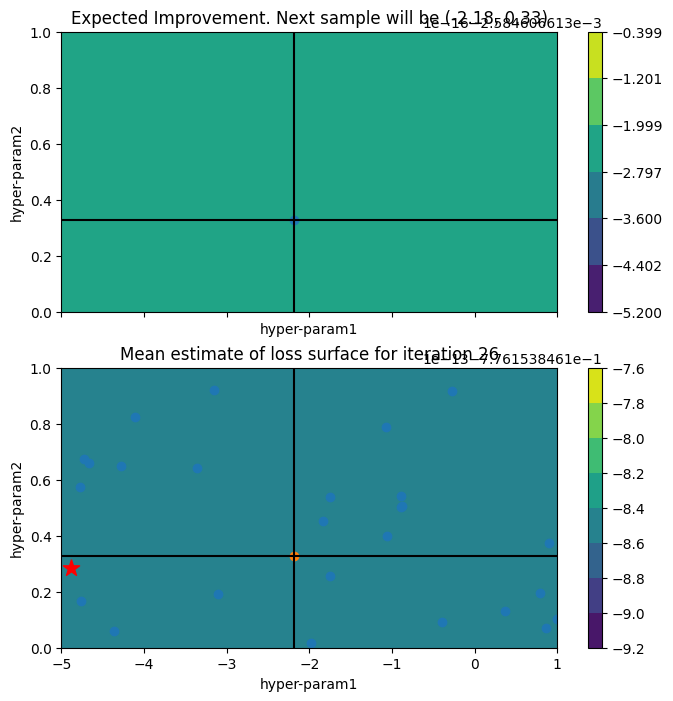

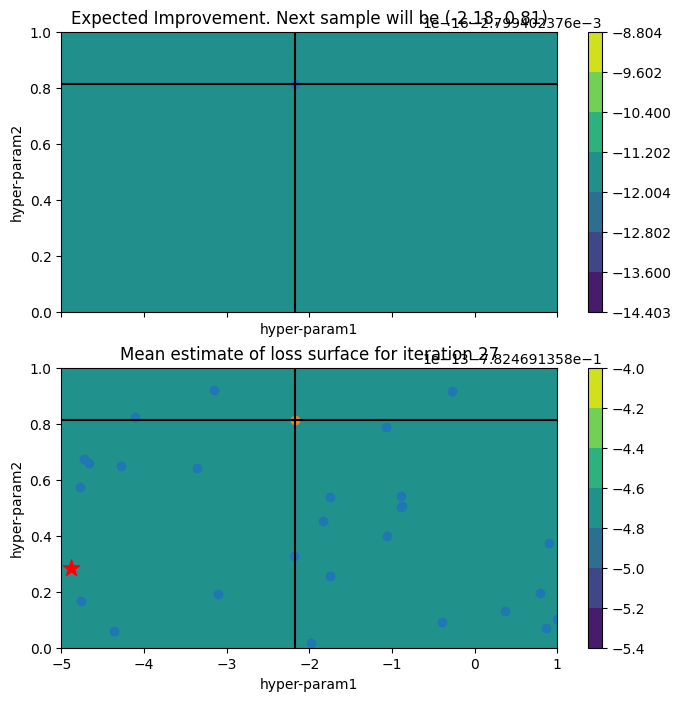

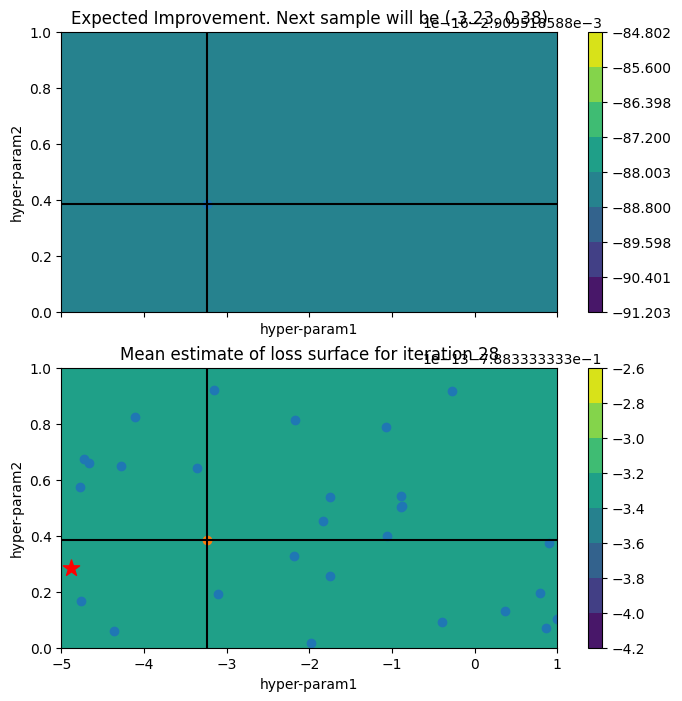

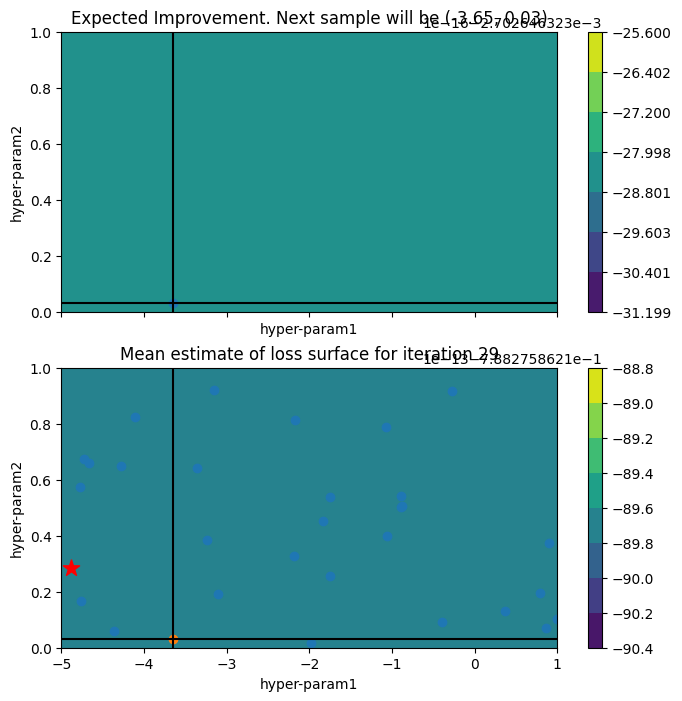

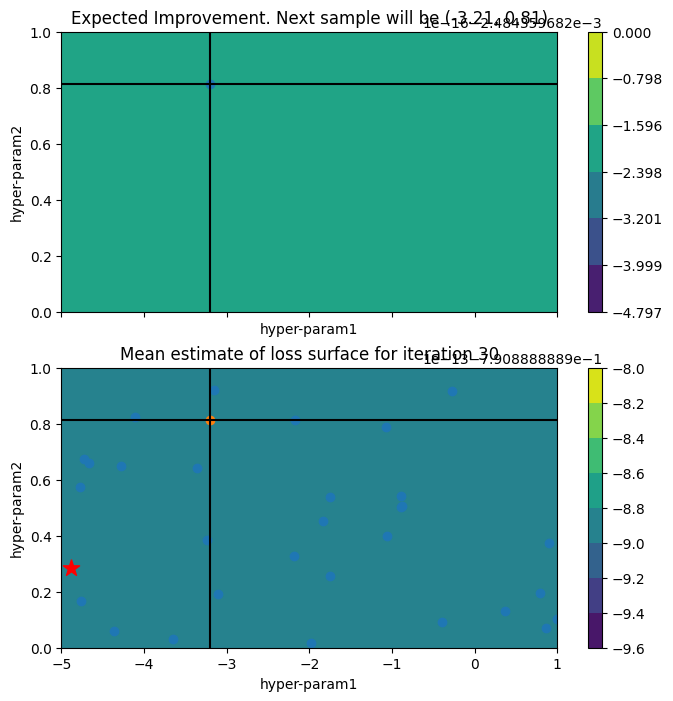

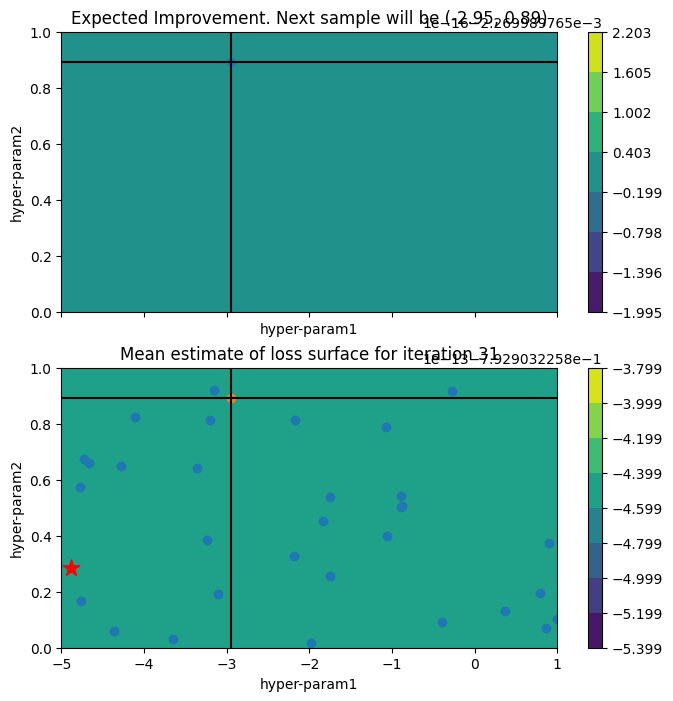

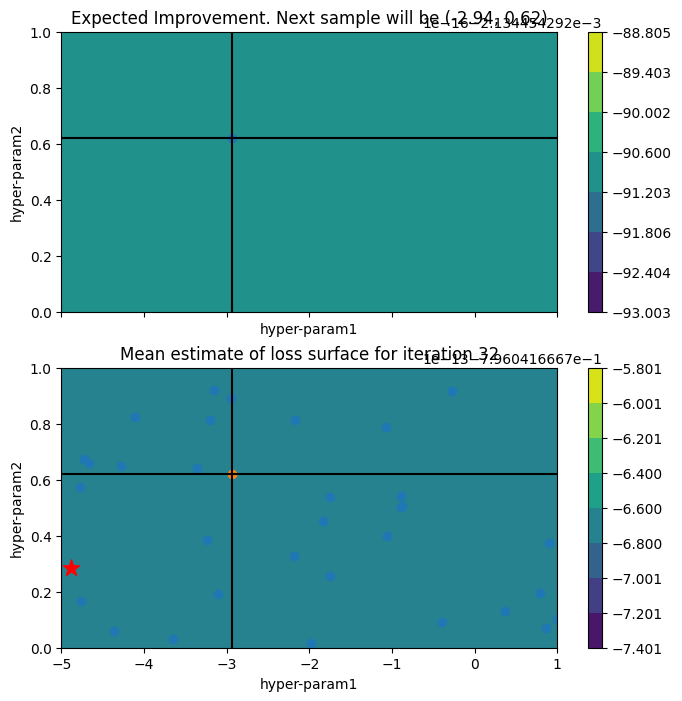

In [16]:
rc('text', usetex=False)
plot_iteration(alphas, xp, yp, first_iter=3, second_param_grid= l1_ratios , optimum=maximum, filepath='./Images_of_sgdC_on_irisdataset') 

We see that the algorithm does not tend towards the optimal point (red star) determined previously. However, the optimum point obtained during the last iterations is in a rather weak iso-value zone, which reassures us in the convergence of the algorithm towards optimal values.

## 2. SVM Classifier (SVC)

In [17]:
def sample_loss2(params):
    return -cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=12345),
                           X=data, y=target, cv=3,scoring='roc_auc').mean()

###Grid search

In [18]:

Cs = np.linspace(-3, 3, 50)
gammas = np.linspace(-4, 1, 50)


param_grid = np.array([[C, gamma] for gamma in gammas for C in Cs])


real_loss = [sample_loss2(params) for params in param_grid]

maximum=param_grid[np.array(real_loss).argmax(), :]
maximum

array([-3., -4.])

### Bayesian search

In [26]:

bounds = np.array([[-3,3], [-4, 1]])

xp, yp = bayesian_optimisation(n_iters=50,
                               sample_loss=sample_loss2,
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)
print("Evaluated points:")
# print(xp)
print("Corresponding losses:")
# print(yp)

# Find the best parameters
best_index = np.argmin(yp)
best_x = xp[best_index]
best_y = yp[best_index]

# Output the best parameters and best accuracy
print(f"Best parameters: C={10 ** best_x[0]}, gamma={10 ** best_x[1]}")
print(f"Best accuracy: {-best_y}")

Evaluated points:
Corresponding losses:
Best parameters: C=337.63544156295814, gamma=0.007692562931144237
Best accuracy: 0.9838251866645008


In [ ]:
rc('text', usetex=False)
plot_iteration(Cs, xp, yp, first_iter=3, second_param_grid=gammas, optimum=maximum) #, filepath='.'

## 3.Using a new binary classification dataset (with make_classification)

This time we create a new dataset on which we will apply the SVC algorithm

In [21]:
seed = 42 # Set seed for reproducibility purposes
kFoldSplits = 3

np.random.seed(seed)

data, target = datasets.make_classification(n_samples=2000,
                                   n_features=45,
                                   n_informative=15,
                                   n_redundant=5)

In [22]:
best_score=1.0
score_history = []
best_score_history = []

def sample_loss3(params) :
    global best_score

    kfold = StratifiedKFold(n_splits=kFoldSplits, random_state=seed, shuffle=True)
    score  = - cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], degree=int(params[2]),random_state=seed),
                           X=data, y=target, cv=kfold,scoring='roc_auc').mean()

    score_for_history = 1+score
    if (score_for_history < best_score):
        best_score=score_for_history

    # # To visualize, we need to modify our objective function to capture history
    best_score_history.append(1-best_score)
    score_history.append(1-score_for_history)

    return score

In [ ]:


#Cs = np.linspace(5, -1, 25)
Cs = np.linspace(-3, 2, 10)

#gammas = np.linspace(-1, -7, 25)
gammas = np.linspace(-4,1, 10)
degrees = np.linspace(2,5,10)

param_grid = np.array([[C, gamma, degree] for gamma in gammas
                       for C in Cs
                       for degree in degrees
                       ])

real_loss = [sample_loss3(params) for params in param_grid]


maximum=param_grid[np.array(real_loss).argmax(), :]
maximum

In [23]:

bounds = np.array([[-3, 3], [-4, 1],[2,6]])

xp, yp = bayesian_optimisation(n_iters=50,
                               sample_loss=sample_loss3,
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)

print("Evaluated points:")
# print(xp)
print("Corresponding losses:")
# print(yp)

# Find the best parameters
best_index = np.argmin(yp)
best_x = xp[best_index]
best_y = yp[best_index]

# Output the best parameters and best accuracy
print(f"Best parameters: C={10 ** best_x[0]}, gamma={10 ** best_x[1]}, degree={int(best_x[2])}")
print(f"Best accuracy: {-best_y}")

Evaluated points:
Corresponding losses:
Best parameters: C=0.0046604707843138455, gamma=0.04323183935479269, degree=4
Best accuracy: 0.9527207626556186


In [27]:
bayesian_roc_auc = -yp

In [ ]:
rc('text', usetex=False)
plot_iteration(Cs, xp, yp, first_iter=3, second_param_grid=gammas, optimum=maximum, filepath='.')

In this case, we see a rapid convergence of hyper-parameters 1 and 2 towards the calculated theoretical value.

The slight difference with the "theoretical value" can be explained by the fact that it is chosen from a limited number of values ​​in a grid of values ​​(therefore subject to approximation).

### Visualizing Bayesians Search Pattern

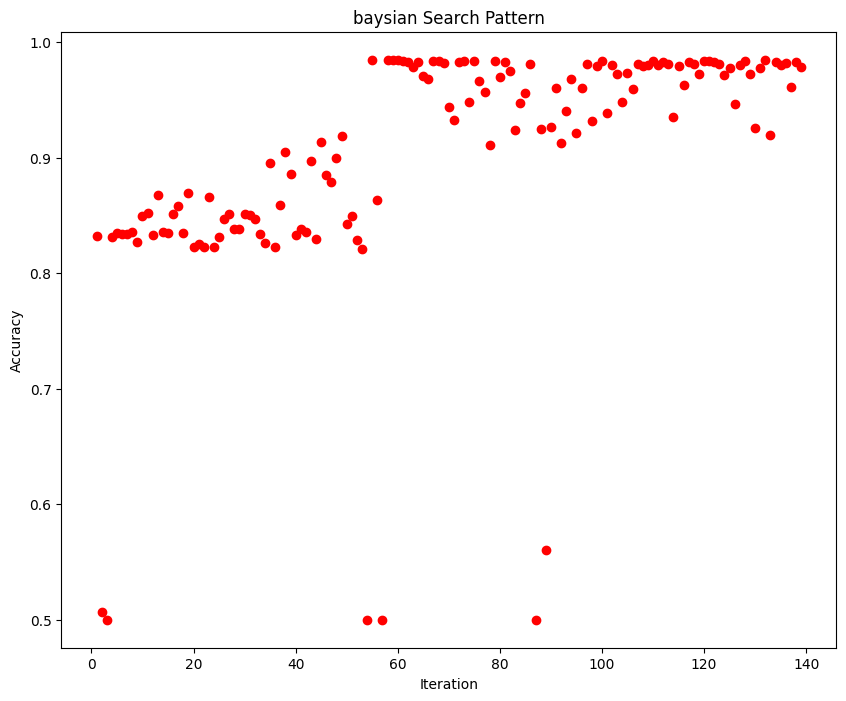

In [180]:
plotY_bayes = score_history
plotX_bayes = list(range(1, len(plotY_bayes)+1, 1))

plt.figure(figsize=(10,8))
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('baysian Search Pattern')
plt.plot(plotX_bayes, plotY_bayes, 'ro')

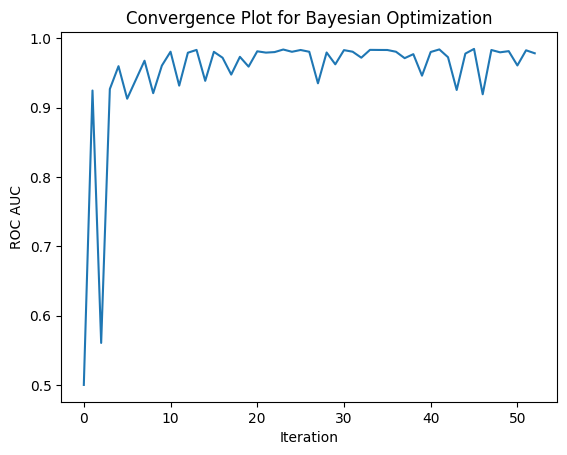

In [181]:
# Plot convergence
plt.figure()
plt.plot(-yp)
plt.title('Convergence Plot for Bayesian Optimization')
plt.xlabel('Iteration')
plt.ylabel('ROC AUC')
plt.show()

### visualizing how the objective function values change as the hyperparameters change for bayesian

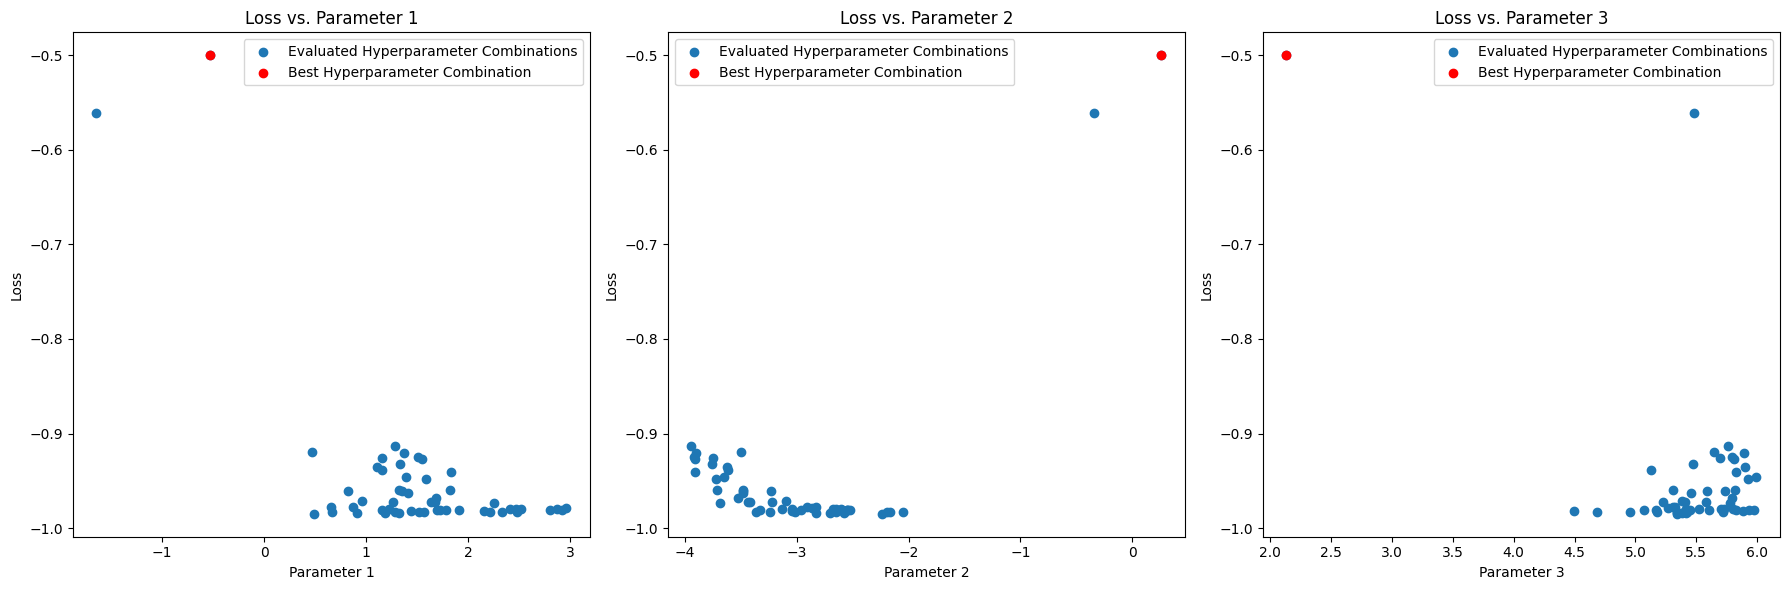

In [182]:
import matplotlib.pyplot as plt

def plot_obj_vs_bay(xp, yp, bounds):
    # Number of hyperparameters
    n_params = bounds.shape[0]

    # Create a new figure with subplots side by side for each hyperparameter
    fig, axes = plt.subplots(1, n_params, figsize=(6 * n_params, 6))

    # If there's only one parameter, make axes iterable
    if n_params == 1:
        axes = [axes]

    for idx in range(n_params):
        # Extract the values of the given hyperparameter
        hp_values = xp[:, idx]

        # Extract the corresponding objective function values
        objective_values = yp

        # Create the scatter plot
        axes[idx].scatter(hp_values, objective_values, label='Evaluated Hyperparameter Combinations')

        # Highlight the best hyperparameters
        best_idx = np.argmax(objective_values)
        best_hp_value = hp_values[best_idx]
        best_objective_value = objective_values[best_idx]

        axes[idx].scatter(best_hp_value, best_objective_value, color='red', label='Best Hyperparameter Combination')
        axes[idx].set_xlabel(f'Parameter {idx+1}')
        axes[idx].set_ylabel('Loss')
        axes[idx].set_title(f'Loss vs. Parameter {idx+1}')
        axes[idx].legend()

    plt.tight_layout()
    plt.show()

# Example usage with the updated plot function
# Assuming `xp` (evaluated points) and `yp` (corresponding losses) are defined from your Bayesian optimization
plot_obj_vs_bay(xp, yp, bounds)


### HyperOpt

In [184]:
from hyperopt import fmin, tpe, hp, Trials ,rand, STATUS_OK
from hyperopt.pyll.base import scope

best_score=1.0
score_history = []
best_score_history = []
# Define the objective function for Hyperopt
def hyperopt_objective(params):
    global best_score
    kfold = StratifiedKFold(n_splits=kFoldSplits, random_state=seed, shuffle=True) # KFold is also an option.
    clf = SVC(**params)
    score= -cross_val_score(clf, X=data, y=target, cv=kfold, scoring='roc_auc').mean()

    score_for_history = 1 + score

    if (score_for_history < best_score):
        best_score=score_for_history

    # To visualize, we need to modify our objective function to capture history
    best_score_history.append(1-best_score)
    score_history.append(1-score_for_history)

    return score


# Define the search space
space = {
    # 'C': hp.choice('C', np.arange(0.005,1.0,0.01)),
    # 'gamma': hp.Choice('gamma',),

    'C': hp.loguniform('C', -3,3),  # C ranges from 0.01 to 1000
    'gamma': hp.loguniform('gamma', -4, 1),  # gamma ranges from 0.001 to 100
    'degree': hp.choice('degree', [2, 3, 4, 5,6])  # degree ranges from 2 to 6
}

# Run Hyperopt
trials = Trials()
best = fmin(fn=hyperopt_objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

100%|██████████| 50/50 [00:40<00:00,  1.22trial/s, best loss: -0.9777919089443402]


In [185]:
# Find the best parameters
best_score = trials.best_trial['result']['loss']
best_params = trials.best_trial['misc']['vals']
print(best_params)
print(best_score)

{'C': [7.243598198667155], 'degree': [1], 'gamma': [0.01867828488061305]}
-0.9777919089443402


### Visualizing Hyperopt’s Search Pattern




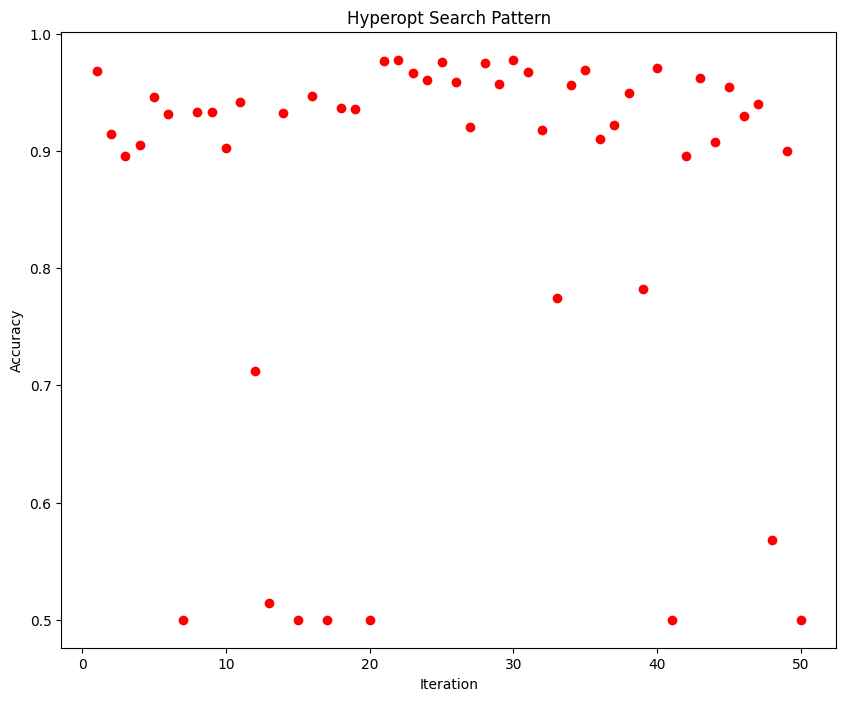

In [186]:
plotY = score_history
plotX = list(range(1, len(plotY)+1, 1))
plt.figure(figsize=(10,8))
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Hyperopt Search Pattern')
plt.plot(plotX, plotY, 'ro')

[0.9685768641595285, 0.9143795455076381, 0.8959281958061763, 0.905137672030051, 0.9459395321286047, 0.9317791525030544, 0.5, 0.9334973206620049, 0.9328676386567146, 0.9026983571205959, 0.942082792096374, 0.7119818635139378, 0.5143708531198338, 0.9327597625022341, 0.5, 0.9472503351549317, 0.5, 0.9365167392752686, 0.9359260009782558, 0.5, 0.9768620679226805, 0.9775999520469939, 0.9666807827422782, 0.9609136550712024, 0.9761812275933331, 0.9587469144286936, 0.920073294938332, 0.9746875856222835, 0.9570666305932573, 0.9777919089443402, 0.9675029649191527, 0.9179360721960758, 0.7747490706841433, 0.9558752664081043, 0.9686038467800046, 0.9101058017523491, 0.9224047291660216, 0.9492303705510593, 0.7818039529720088, 0.9711448399903442, 0.5, 0.8957440032031448, 0.962558028479522, 0.9073733496460478, 0.9543719994284755, 0.9294084395479741, 0.9402654220616062, 0.5679149116645144, 0.9001025158486677, 0.5]


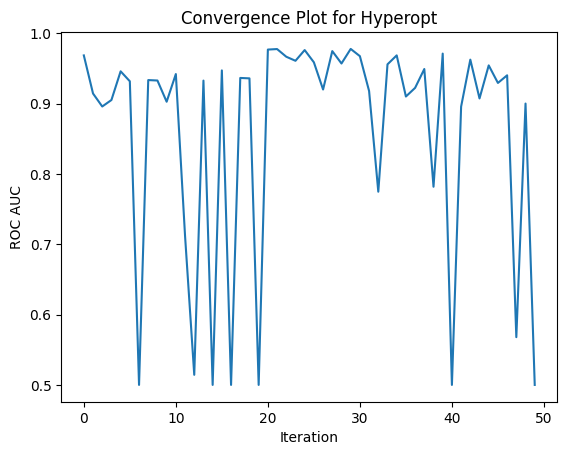

In [187]:
hyperopt_roc_auc = [-trial['result']['loss'] for trial in trials.trials]
print(hyperopt_roc_auc)
plt.figure()
plt.plot(hyperopt_roc_auc)
plt.title('Convergence Plot for Hyperopt')
plt.xlabel('Iteration')
plt.ylabel('ROC AUC')
plt.show()

### Visualizing how the objective function values change as the hyperparameters change for hyperopt

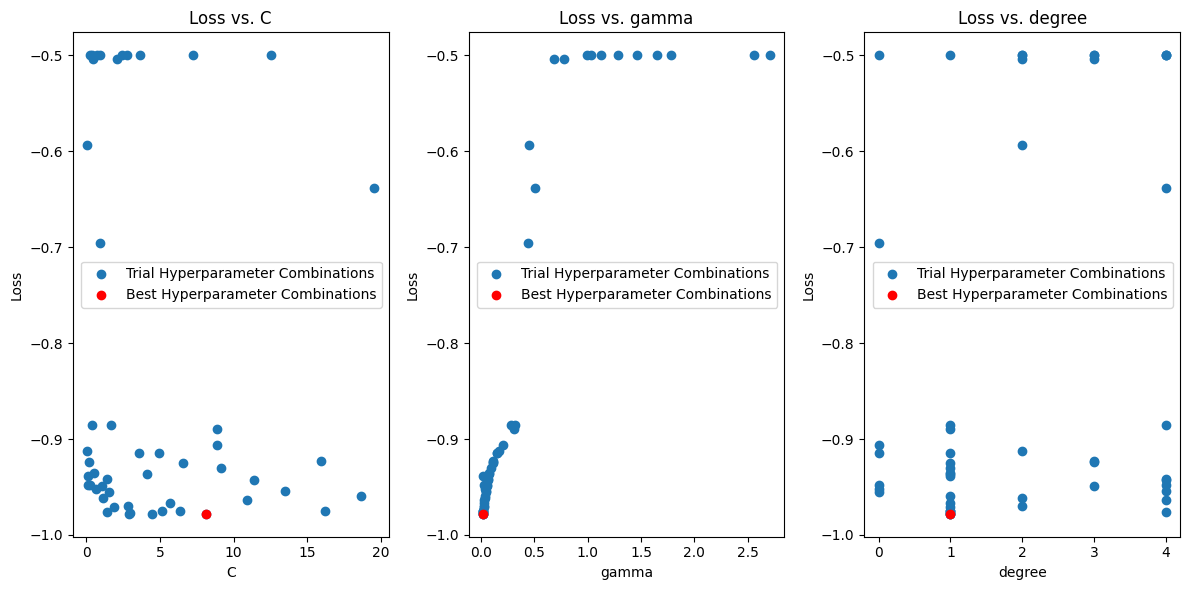

In [160]:
def plot_obj_vs_hp(trials,space, best):
    # Extract the results
    results = trials.trials

    # Create a list of hyperparameters
    hyperparameters = list(space.keys())

    # Create a new figure with 2 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))

    # Loop through hyperparameters and generate plots
    for idx, hp in enumerate(hyperparameters):
        # Extract the values of a given hyperparameter
        hp_values = [res['misc']['vals'][f'{hp}'] for res in results]

        # Flatten the list of values
        hp_values = [item for sublist in hp_values for item in sublist]

        # Extract the corresponding objective function values
        objective_values = [res['result']['loss'] for res in results]

        # Create the scatter plot
        axes[idx].scatter(hp_values, objective_values, label='Trial Hyperparameter Combinations')

        # Highlight the best hyperparameters
        axes[idx].scatter(best[hp], min(objective_values), color='red', label='Best Hyperparameter Combinations')
        axes[idx].set_xlabel(f'{hp}')
        axes[idx].set_ylabel('Loss')
        axes[idx].set_title(f'Loss vs. {hp}')
        axes[idx].legend()

    plt.tight_layout()
    plt.show()
# Plot optimization vs. hyperparameters in 2D
plot_obj_vs_hp(trials,space, best)

### Comparison between Bayesian and hyperopt for SVM

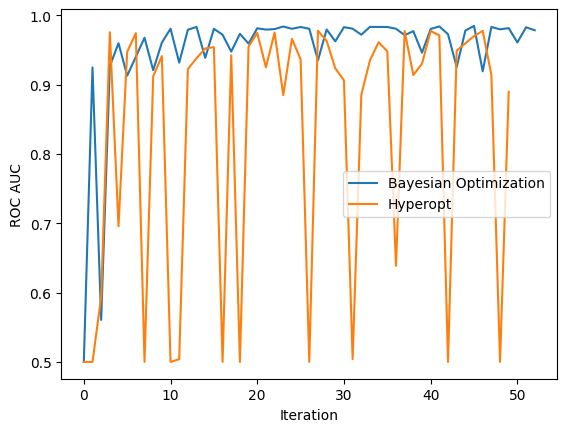

Best ROC AUC for Bayesian Optimization:  0.9848673586893907
Best ROC AUC for Hyperopt:  0.9779268401558617


In [183]:
plt.figure()
plt.plot(bayesian_roc_auc, label='Bayesian Optimization')
plt.plot(hyperopt_roc_auc, label='Hyperopt')
# plt.plot(random_search_roc_auc, label='Random Search')
# plt.title('Learning Rate Distribution Curves')
plt.xlabel('Iteration')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

# Print best results
print("Best ROC AUC for Bayesian Optimization: ", max(bayesian_roc_auc))
print("Best ROC AUC for Hyperopt: ", max(hyperopt_roc_auc))
# print("Best ROC AUC for Random Search: ", max(random_search.best_score_))

## Trying all these stuff for Xgboost

### Bayesian Optimization for xgboost

In [230]:
import xgboost as xgb

# Sample loss function for XGBoost
def sample_loss_xgb(params):
    learning_rate = 10 ** params[0]
    max_depth = int(params[1])
    subsample = params[2]

    xgbm = xgb.XGBClassifier(learning_rate=learning_rate, max_depth=max_depth, subsample=subsample, random_state=12345,scoring='roc_auc')
    return -cross_val_score(xgbm, X=data, y=target, cv=3,scoring='roc_auc').mean()

In [231]:
# Define bounds for the hyperparameters (log scale for learning_rate, integer for max_depth, linear for subsample)
bounds = np.array([[-4, 0], [1, 10], [0.5, 1.0]])


xp, yp = bayesian_optimisation(n_iters=50,
                               sample_loss=sample_loss_xgb,
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)


print("Evaluated points:")
# print(xp)
print("Corresponding losses:")
# print(yp)

best_index = np.argmax(yp)
best_x = xp[best_index]
best_y = yp[best_index]


print(f"Best parameters: learning_rate={10 ** best_x[0]}, max_depth={int(best_x[1])}, subsample={best_x[2]}")
print(f"Best accuracy: {-best_y}")

Evaluated points:
Corresponding losses:
Best parameters: learning_rate=0.0001050917805194113, max_depth=5, subsample=0.7206182510940703
Best accuracy: 0.9003127856151124


In [231]:
plot_obj_vs_bay(xp,yp, best)

### hyperopt for Xgboost

In [200]:

space = {
    'learning_rate': hp.loguniform('learning_rate', -4, 0),
    'max_depth': hp.quniform('max_depth', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0)
}

def objective(params):
    clf = xgb.XGBClassifier(
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        subsample=params['subsample'],
        random_state=12345
    )

    score = cross_val_score(clf, X=data, y=target, cv=3,scoring='roc_auc').mean()
    return -score


trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print(f"Hyperopt Best parameters: learning_rate={best['learning_rate']}, max_depth={int(best['max_depth'])}, subsample={best['subsample']}")
print(f"Hyperopt Best accuracy: {-min(trials.losses())}")


100%|██████████| 50/50 [01:49<00:00,  2.20s/trial, best loss: -0.9723336417320089]
Hyperopt Best parameters: learning_rate=0.2762698074411083, max_depth=6, subsample=0.9130991344875099
Hyperopt Best accuracy: 0.9723336417320089


In [ ]:
plot_obj_vs_hp(trials,space, best)

### Randomsearch for Xgboost

In [202]:
from sklearn.model_selection import RandomizedSearchCV


param_dist = {
    'learning_rate': np.logspace(-4, 0, 25),
    'max_depth': np.arange(1, 11),
    'subsample': np.linspace(0.5, 1.0, 25)
}

clf = xgb.XGBClassifier(random_state=0)
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=50, cv=3, scoring='roc_auc', random_state=0)
random_search.fit(data, target)
random_search_roc_auc = random_search.cv_results_['mean_test_score']

best_params = random_search.best_params_
best_x = np.array([np.log10(best_params['learning_rate']), best_params['max_depth'], best_params['subsample']])

print(f"Random Search Best parameters: learning_rate={best_params['learning_rate']}, max_depth={best_params['max_depth']}, subsample={best_params['subsample']}")
print(f"Random Search Best ROC AUC: {random_search.best_score_}")

Random Search Best parameters: learning_rate=0.1467799267622069, max_depth=8, subsample=0.625
Random Search Best ROC AUC: 0.9700049057663671


In [ ]:
# plot_obj_vs_hp(trials,space, best)

### Plotting Comparison od learning rate distribution between all these  three

#### Start plotting the distributions of hyperparameter values searched. We expect random search to align with the search domain, while the Bayesian hyperparameter optimization should tend to focus on more promising values, wherever those happen to be in the search domain.

####The dashed vertical lines indicate the "optimal" value of the hyperparameter.

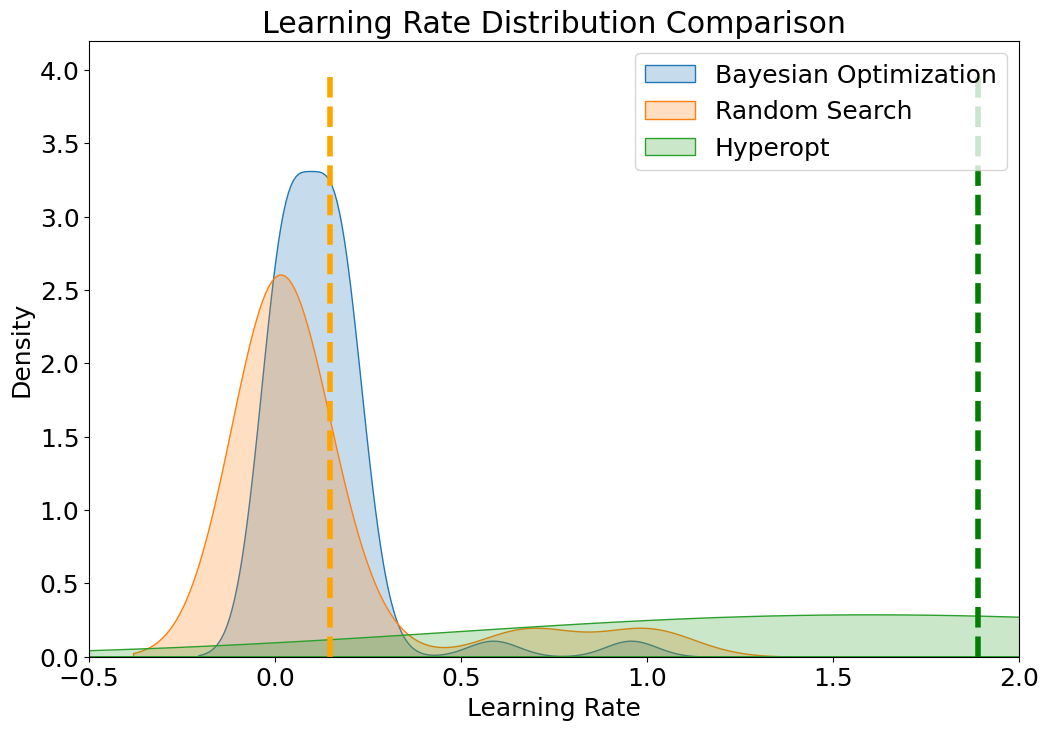

In [240]:
# Extract learning rates
def extract_learning_rates_rs_cv(results, param_name='param_learning_rate'):
    learning_rates = results[param_name].data
    return [lr for lr in learning_rates]

def extract_learning_rates(all_params, index=0):
    return [param[index] for param in all_params]

rs_learning_rates = extract_learning_rates_rs_cv(random_search.cv_results_, 'param_learning_rate')
bo_learning_rates = extract_learning_rates(xp, 0)
ho_learning_rates = [trial['misc']['vals']['learning_rate'][0] for trial in trials.trials]

# Convert log-transformed learning rates to actual values for comparison
bo_learning_rates = [10 ** lr for lr in bo_learning_rates]
ho_learning_rates = [10 ** lr for lr in ho_learning_rates]

plt.figure(figsize=(12, 8))

# Density plots of the learning rate distributions
sns.kdeplot(bo_learning_rates, label='Bayesian Optimization',shade=True)
sns.kdeplot(rs_learning_rates, label='Random Search', shade=True)
sns.kdeplot(ho_learning_rates, label='Hyperopt', shade=True)
plt.vlines([best_params['learning_rate'],10**best['learning_rate']],
           ymin = 0.0, ymax = 4.0, linestyles = '--', linewidth = 4, colors = ['orange', 'green'])
plt.xlabel('Learning Rate')
plt.ylabel('Density')
plt.title('Learning Rate Distribution Comparison')
plt.xlim([-0.5, 2])  # Adjust x-axis limits
plt.legend()
plt.show()
